In [ ]:

%matplotlib inline
!pip uninstall opencv-python -y
# downgrade OpenCV a bit since some none-free features are not avilable
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 143kB/s 
     |████████████████████████████████| 14.6MB 163kB/s 
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import math
import cv2

In [ ]:
data_path = 'drive/My Drive/'
img_file = glob.glob(os.path.join(data_path, 'original_img/*'))

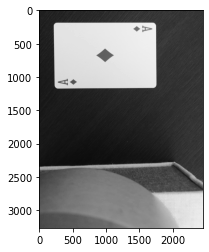

In [ ]:
##This cell is reading an image and showing it
GlobalPath="drive/My Drive/original_img/d1.jpg"
img = cv2.imread(GlobalPath)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')


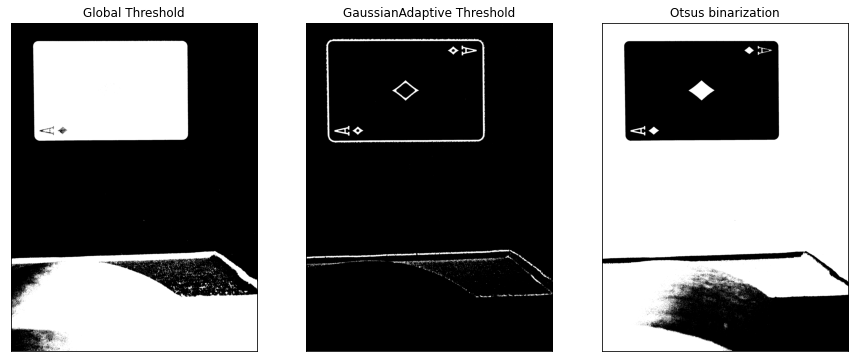

In [ ]:
##This cell is showing Thresholds 
ret, thresh = cv2.threshold(gray, 80, 255, cv2.THRESH_TOZERO_INV)
ret, thresh = cv2.threshold(1-thresh, 80, 255, cv2.THRESH_TOZERO_INV)

thresh2 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 99, 20)

thresh3 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]


plt.figure(figsize=(15,15))
plt.subplot(131),plt.imshow(thresh,cmap = 'gray')
plt.title('Global Threshold'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(thresh2,cmap = 'gray')
plt.title('GaussianAdaptive Threshold'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(thresh3,cmap = 'gray')
plt.title('Otsus binarization'), plt.xticks([]), plt.yticks([])

plt.show()


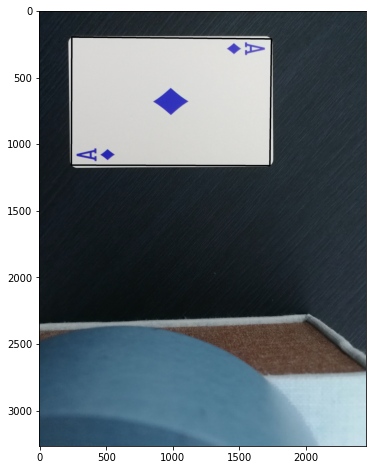

In [ ]:
##Find Contours and Show it
contours = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[1]
th_area = img.shape[0] * img.shape[1] / 100
contours_large = list(filter(lambda c:cv2.contourArea(c) > th_area, contours))
approxes = []
for (i,cnt) in enumerate(contours_large):
    arclen = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.1*arclen, True)
    if len(approx) < 4:
        continue
    approxes.append(approx)
test = np.copy(img)
cv2.polylines(test, approxes,True,(0,0,0),10)
plt.figure(figsize=(8,8))
plt.imshow(test)



True

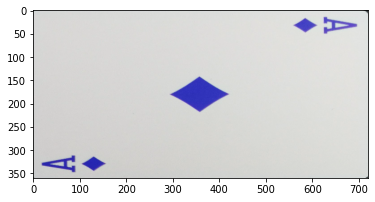

In [ ]:
##This Cell is about deciding whether a found card is horizontal or perpendicular
sliceindexOfCardsXaxis=[]
sliceindexOfCardsYaxis=[]
for i in range(len(approxes[0])):
    sliceindexOfCardsXaxis.append(approxes[0][i][0][0])
for i in range(len(approxes[0])):
    sliceindexOfCardsYaxis.append(approxes[0][i][0][1])

crop_img = img[min(sliceindexOfCardsYaxis):max(sliceindexOfCardsYaxis), min(sliceindexOfCardsXaxis):max(sliceindexOfCardsXaxis)]

xAxis,yAxis,color=crop_img.shape
if xAxis<yAxis:
    crop_img = cv2.resize(crop_img,(720,360))
else:
    crop_img = cv2.resize(crop_img,(360,720))
plt.imshow(crop_img)
cv2.imwrite('test5.png',crop_img)




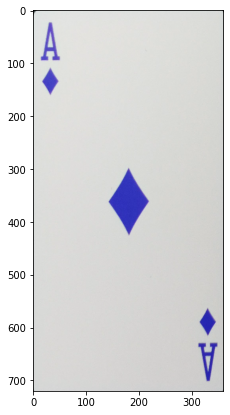

In [ ]:
##This cell is about if card is not perpendicular or horizontal , (In order to calculate correctly affine transformation later) Rotate card 
if np.average(crop_img[:163,:76])>205:
    crop_img=cv2.rotate(crop_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
plt.figure(figsize=(7,7))
plt.imshow(crop_img)


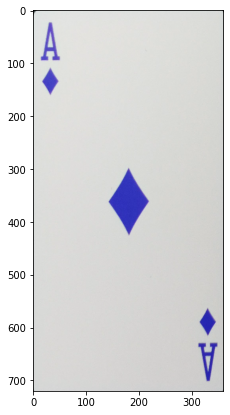

In [ ]:
#Rotate Card If it is horizontal, No need to do it Perpendicular cards.

operatedImage = cv2.cvtColor(crop_img[0:140,150:218], cv2.COLOR_BGR2GRAY) 
  
operatedImage = np.float32(operatedImage) 
  
dest = cv2.cornerHarris(operatedImage, 2, 5, 0.07) 
  
dest = cv2.dilate(dest, None) 
  
ControlingForRotateArray=[dest > 0.01 * dest.max()]
uniqueValues, occurCount = np.unique(ControlingForRotateArray, return_counts=True)

if np.average(crop_img[:163,:76])<205 and occurCount[1]>50:
    crop_img=cv2.rotate(crop_img, cv2.ROTATE_90_COUNTERCLOCKWISE)

plt.figure(figsize=(7,7))
plt.imshow(crop_img)






Edge Points For Rotate 0 207
Edge Points For Rotate 719 154
Edge Points For Rotate 423 0


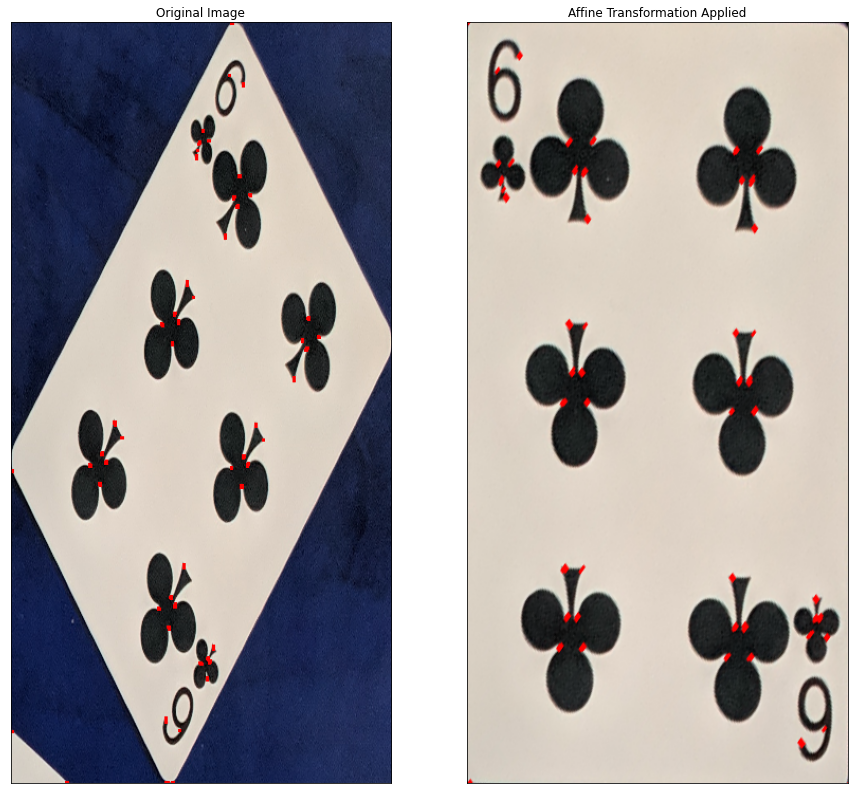

In [ ]:
##This cells for Cards not standing horizontally or vertically
#In While loops we try to find corner points for Affine Transformation on matrix that we obtained from Harris Corner Detection.
#When we find these points , we applied affine transformation , so that obtain a card perpendicular.


IMAGE=cv2.imread("drive/My Drive/NotHorizontal.png")
rows, cols,ch = crop_img.shape 

operatedImage = cv2.cvtColor(IMAGE, cv2.COLOR_BGR2GRAY) 




dest = cv2.cornerHarris(operatedImage, 2, 5, 0.07) 
dest = cv2.dilate(dest, None) 
N=dest > 0.1 * dest.max()




IMAGE[dest > 0.1 * dest.max()]=(255,0,0)


Xindex=N.shape[0]
Yindex=N.shape[1]


FirstXIndexForRotatePoint=1
FirstYIndexForRotatePoint=2
i=0
while i<Xindex:
    j=0
    while j<Yindex:
        if N[i][j] == True:
            FirstXIndexForRotatePoint = i
            FirstYIndexForRotatePoint = j
            if FirstXIndexForRotatePoint != 1 and FirstYIndexForRotatePoint != 2:
                i = Xindex
                j = Yindex
        j=j+1
    i=i+1
print("Edge Points For Rotate "+str(FirstXIndexForRotatePoint),str(FirstYIndexForRotatePoint))

SecondXIndexForRotatePoint=1
SecondYIndexForRotatePoint=2
i=Xindex-1
while i>0:
    j=Yindex-1
    while j>0:
        if N[i][j] == True:
            SecondXIndexForRotatePoint = i
            SecondYIndexForRotatePoint = j
            if SecondXIndexForRotatePoint != 1 and SecondYIndexForRotatePoint != 2:
                i = 0
                j = 0
        j=j-1
    i=i-1
print("Edge Points For Rotate "+str(SecondXIndexForRotatePoint),str(SecondYIndexForRotatePoint))


ThirdXIndexForRotatePoint=1
ThirdYIndexForRotatePoint=2
j=0
while j<Yindex:
    i=0
    while i<Xindex:
        if N[i][j] == True:
            ThirdXIndexForRotatePoint = i
            ThirdYIndexForRotatePoint = j
            if ThirdXIndexForRotatePoint != 1 and ThirdYIndexForRotatePoint != 2:
                i = Xindex
                j = Yindex
        i=i+1
    j=j+1
print("Edge Points For Rotate "+str(ThirdXIndexForRotatePoint),str(ThirdYIndexForRotatePoint))

if ThirdYIndexForRotatePoint>15:
    ThirdYIndexForRotatePoint-15
pt1=np.float32([[FirstYIndexForRotatePoint,FirstXIndexForRotatePoint],[ThirdYIndexForRotatePoint,ThirdXIndexForRotatePoint],[SecondYIndexForRotatePoint,SecondXIndexForRotatePoint]])
pt2=np.float32([[0,0],[0,720],[360,720]])  
M = cv2.getAffineTransform(pt1, pt2) 
dst = cv2.warpAffine(IMAGE, M, (cols, rows)) 


plt.figure(figsize=(15,15))
plt.subplot(121),plt.imshow(IMAGE)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst,cmap = 'gray')
plt.title('Affine Transformation Applied'), plt.xticks([]), plt.yticks([])
plt.show()

You have entered d1


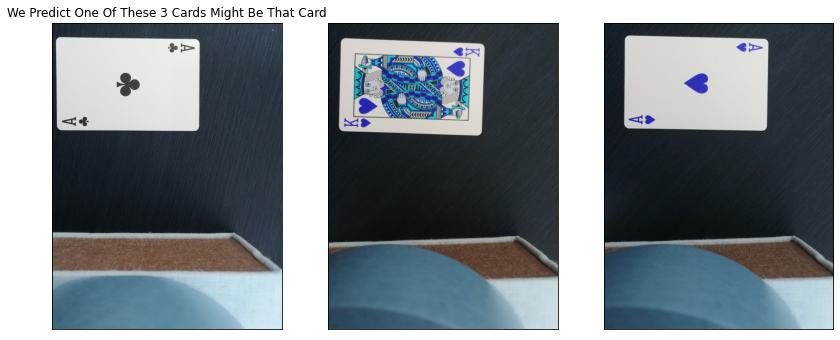

In [ ]:
##This cell tries to find a given card type. We try to match Top Left of Cards because They are unique for all types of cards.
##We substract top left matrixes , If they match the difference should be 0 or lowest difference. 
##This method is not working well , So we find 3 lowest difference and show them.
import os
from heapq import nsmallest
path="drive/My Drive/Cards"
dirListing= os.listdir(path)
TestListForIdentificationCards=[]
croppedLeftSize=np.copy(crop_img[0:160,:52])
croppedLeftSize=cv2.resize(croppedLeftSize,(52,160))
croppedLeftSize=cv2.cvtColor(croppedLeftSize,cv2.COLOR_BGR2GRAY)


for i in range(len(dirListing)):
    ImgPath=path+"/"+dirListing[i]
    TestImg=cv2.imread(ImgPath)
    TestImg=cv2.cvtColor(TestImg,cv2.COLOR_BGR2GRAY)
    a,b=TestImg.shape
    TestImg=TestImg[35:a-65,:]
    TestImg=cv2.resize(TestImg,(52,160))
    TestListForIdentificationCards.append(np.sum(croppedLeftSize-TestImg))

a=TestListForIdentificationCards.index(min(TestListForIdentificationCards))
SmallestValue=nsmallest(3, TestListForIdentificationCards)
PredictedCards=[]
for i in range(len(SmallestValue)):
    PredictedCards.append(dirListing[TestListForIdentificationCards.index(SmallestValue[i])])
path="drive/My Drive/original_img"
PredictedImg1=cv2.imread(path+"/"+PredictedCards[0])
PredictedImg2=cv2.imread(path+"/"+PredictedCards[1])
PredictedImg3=cv2.imread(path+"/"+PredictedCards[2])

print("You have entered {}".format(GlobalPath[28:30]))


plt.figure(figsize=(14,14))
plt.subplot(131),plt.imshow(PredictedImg1)
plt.title('We Predict One Of These 3 Cards Might Be That Card'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(PredictedImg2)
plt.title(' '), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(PredictedImg3)
plt.title('  '), plt.xticks([]), plt.yticks([])

plt.show()


(146, 46)
True


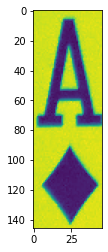

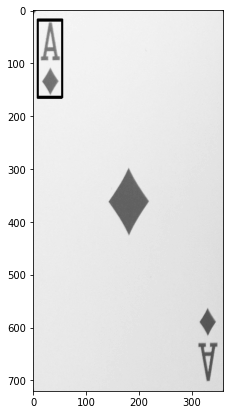

In [ ]:
#Since the avg Score is bad we have tried to apply template matching


template = cv2.imread('drive/My Drive/Cards/d1.jpg',0)
template=template[35:340,40:]
template=cv2.resize(template,(46,146))
plt.imshow(template)
print(template.shape)
w, h = template.shape[::-1]

img_gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)

loc = np.where( res >= 0.85)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_gray, pt, (pt[0] + w, pt[1] + h), (0,255,255), 2)

threshold = 0.7
flag = False
if np.amax(res) >= threshold:
    flag = True
print(flag)
cv2.imwrite('test5.png',crop_img)
plt.figure(figsize=(7,7))
plt.imshow(img_gray,cmap="gray")

You have entered d1
We have Found that d1


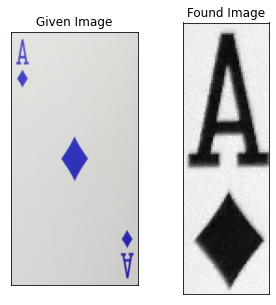

In [ ]:
#We itarete throgh the identifying parts of cards , 
#When we found the card we stop iterating and show the results.
path="drive/My Drive/Cards"
dirListing= os.listdir(path)

Path=""
template=[]
for i in range(len(dirListing)):

    img_gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
    ImgPath=path+"/"+dirListing[i]
    template=cv2.imread(ImgPath)
    template=template[35:340,40:]
    template=cv2.resize(template,(46,146))


    template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    w, h = template.shape[::-1]

    res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)

    loc = np.where( res >= 0.85)
    for pt in zip(*loc[::-1]):
        cv2.rectangle(img_gray, pt, (pt[0] + w, pt[1] + h), (0,255,255), 2)

    threshold = 0.85
    flag = False
    if np.amax(res) >= threshold:
        flag = True
        Path=ImgPath
        break

print("You have entered {}".format(GlobalPath[28:30]))
print("We have Found that {}".format(Path[21:23])) 
        

plt.figure(figsize=(5,5))
plt.subplot(121),plt.imshow(crop_img)
plt.title('Given Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(template,cmap = 'gray')
plt.title('Found Image'), plt.xticks([]), plt.yticks([])
plt.show()
    
    
